# Using seq2seq models to represent duplicate questions

This notebook (and the whole project in general) is dedicated to Quora Kaggle competition where I am supposed to build a model to determine whether two given Quora questions are duplicates of each other

For me personally this is a great motivation to try out RNNs so my plan for now is to build some basic encoder-decoder model where I take a question and translate it to its duplicate - this way I could represent original questions with ~100-dimensional vectors and carry on with classification task from there

However, there is a catch - the training dataset in this competition consists of only ~400K question pairs and it is somewhat conventionally assumed that RNNs are really demanding in terms of training samples and these ~400K may not be enough 

To circumvent this problem, in my seq2seq model I will focus on word embeddings (i.e. in the decoding stage of my model I will predict not the actual words but their embeddings - as their dimension is way smaller than the number of all words that should drastically decrease the number of model parameters so that I would have a better match with a small training sample) - I believe this approach looks interesting in its own right

## Importing necessary stuff

For this project all DL related stuff is handled with keras (version 2.0.x whcih is important as I use merge layers in my model) on top of theano (although I do not make use of any theano-specific features yet)

In [1]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Embedding, LSTM, RepeatVector, Lambda
from keras.layers.merge import Concatenate
from keras.preprocessing.sequence import pad_sequences

Using Theano backend.


On the NLP side I am interested in word embeddings - as of now I am just building model prototype, I decided to generate them on the fly with gensim implementation of word2vec

In [2]:
import re
from gensim.models import Word2Vec
import nltk

C:\Users\lyapin roman\Anaconda2\envs\dl_env\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Importing remaining libraries - note cosine_similarity fucntion - later on I manage to get question encodings and compare them between duplicates and non-duplicates

In [3]:
import os.path
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)  
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

## Reading the corpus and setting model parameters

In [5]:
WORD_EMBEDDING_DIM = 100
QUESTION_ENCODING_DIM = 100

Regarding the corpus for my model: for now I leave the test set aside as my original plan involved translating quesitons to their duplicates (and I need true labels to select those)

In [6]:
train_df = pd.read_csv("train.csv.zip", sep=",", compression="zip")
print("The size of training sample: " + str(len(train_df)))
train_df.head()

The size of training sample: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


## Cleaning the corpus and getting word2vec embeddings

To process the corpus I cast everything to lowercase and throw away everything that is not alphanumeric - I also made use of nltk stopwords (however, after inspection it turned out that this stoplist contained words that could define the meaning of the questions - in the future it might make sense to get rid of the stopwords altogether)

In [7]:
stopwords = set(nltk.corpus.stopwords.words("english"))
stopwords = stopwords.difference(set(["can", "who", "any", "which", "when", "whom", 
                                      "if", "what", "how", "why", "where", "only", "same", "more", "now"
                                     ]))

def process_question(raw_question):
    tokens = re.sub(r"[^a-z0-9]+", " ", str(raw_question).lower()).split()
    return [x for x in tokens if x not in stopwords]

In [8]:
corpus = []
seen_ids = set()

for index, row in train_df.iterrows():
    q1_id = row["qid1"]
    if q1_id not in seen_ids:
        corpus.append(process_question(row["question1"]))
        seen_ids.add(q1_id)
    q2_id = row["qid2"]
    if q2_id not in seen_ids:
        corpus.append(process_question(row["question2"]))
        seen_ids.add(q2_id)    
        
print("The number of unique questions in the corpus: " + str(len(corpus)))
print(corpus[:10])

The number of unique questions in the corpus: 537933
[['what', 'step', 'step', 'guide', 'invest', 'share', 'market', 'india'], ['what', 'step', 'step', 'guide', 'invest', 'share', 'market'], ['what', 'story', 'kohinoor', 'koh', 'noor', 'diamond'], ['what', 'would', 'happen', 'if', 'indian', 'government', 'stole', 'kohinoor', 'koh', 'noor', 'diamond', 'back'], ['how', 'can', 'increase', 'speed', 'internet', 'connection', 'using', 'vpn'], ['how', 'can', 'internet', 'speed', 'increased', 'hacking', 'dns'], ['why', 'mentally', 'lonely', 'how', 'can', 'solve'], ['find', 'remainder', 'when', 'math', '23', '24', 'math', 'divided', '24', '23'], ['which', 'one', 'dissolve', 'water', 'quikly', 'sugar', 'salt', 'methane', 'carbon', 'di', 'oxide'], ['which', 'fish', 'would', 'survive', 'salt', 'water']]


Training word2vec model: note that even if I use pretrained embeddings later I will still need to adapt them to the corpus I have in the competition (to see that it is different enough consider "cat" token - in this competition "cat" refers less to the animal and more to the standardized test)

In [9]:
w2v_embeddings = Word2Vec(corpus, size=WORD_EMBEDDING_DIM)

In [10]:
w2v_embeddings.most_similar(positive=["cat"])

[('xat', 0.7465585470199585),
 ('gmat', 0.7090531587600708),
 ('aipmt', 0.7055665850639343),
 ('percentile', 0.7016848921775818),
 ('clat', 0.6829637289047241),
 ('bitsat', 0.6823551654815674),
 ('sat', 0.6673076152801514),
 ('toefl', 0.666313111782074),
 ('cmat', 0.665096640586853),
 ('iift', 0.6648986339569092)]

## Selecting duplicate question pairs for seq2seq model

In order to push duplicate questions into keras model I first need to encode them (replace tokens in the original questions with indices) - to be able to track what my questions stand for afterwards I dump words and indices into double linked dictionaries

In [11]:
word2index_map = {}
index2word_map = {}
max_question_length = 0
current_index = 1

for index, row in train_df.iterrows():
    tokens_a = process_question(row["question1"])
    tokens_b = process_question(row["question2"])
    max_question_length = max(max_question_length, max(len(tokens_a), len(tokens_b)))
    for token in tokens_a + tokens_b:
        if token not in word2index_map:
            word2index_map[token] = current_index
            index2word_map[current_index] = token
            current_index += 1
            
print("The number of unique words in the corpus: " + str(len(word2index_map)))
print("The size of the longest question: " + str(max_question_length))           

The number of unique words in the corpus: 85180
The size of the longest question: 108


In [12]:
duplicates = train_df[train_df["is_duplicate"] == 1].reset_index()
duplicate_pairs_num = len(duplicates)
print("The number of duplicate question pairs: " + str(duplicate_pairs_num))
duplicates.head()

The number of duplicate question pairs: 149263


,index,id,qid1,qid2,question1,question2,is_duplicate
0,5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1
1,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [13]:
duplicates_left = np.zeros((duplicate_pairs_num, max_question_length))
duplicates_right = np.zeros((duplicate_pairs_num, max_question_length))

for index, row in duplicates.iterrows():
    tokens_left = process_question(row["question1"])
    indices_left = [word2index_map[token] for token in tokens_left]
    duplicates_left[index, :] = pad_sequences([indices_left], maxlen=max_question_length)
    
    tokens_right = process_question(row["question2"])
    indices_right = [word2index_map[token] for token in tokens_right]
    duplicates_right[index, :] = pad_sequences([indices_right], maxlen=max_question_length)

## Building an embedding layer

The embedding layer is essentially one big matrix where each row is occupied with some word embedding (the correspondence between indices and words can be reestablished using dictionaries I define above) - in order to define the embedding layer keras blog turned out to be of great help (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [14]:
embedding_matrix = np.zeros((len(index2word_map) + 1, WORD_EMBEDDING_DIM))
for i in range(1, len(index2word_map) + 1):
    if index2word_map[i] in w2v_embeddings:
        embedding_matrix[i, :] = w2v_embeddings[index2word_map[i]]

In [15]:
embedding_layer = Embedding(input_dim=len(index2word_map)+1,
                            output_dim=WORD_EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_question_length,
                            trainable=False)

## Building encoder-decoder model in keras

After I defined the embedding layer it is time to build my seq2seq model - this section is a heart of the notebook and it took me quite some time to get everything done

The problem was: I already decided I want my model to predict the embeddings and not actual words - however, I could not really store them as then I would have tensor of (~400000, ~100, 100) and that is too much for my laptop - instead, I had to calculate these embeddings on the fly

This calculation was rather tricky to implement - sparing the details and just giving out my solution to the problem: I have both original and duplicate questions as an input for my model - the original question goes through whole encoder-decoder pipeline and returns the suggested embeddings, the duplicate questions only goes through embedding layer - on top of them I add a dummy layer which explicitly calculates the loss I want (mean squared error) - on top of that I specify dummy loss function which simply takes the output of this final layer as an objective to optimize

Because of that my model does not really have any target variables (my custom_loss makes no use of y_true), yet, in the fit stage I still had to provide some random array (with a proper shape) so that keras would not complain and just do the work

Some links that helped me to go through this nightmare of a setup:
* https://github.com/fchollet/keras/issues/4685
* https://keras.io/getting-started/functional-api-guide/
* https://github.com/fchollet/keras/issues/369
* https://github.com/fchollet/keras/issues/1919


In [16]:
left_input = Input(shape=(max_question_length,))
left_embedded_input = embedding_layer(left_input)
encoded_question = LSTM(units=QUESTION_ENCODING_DIM, return_sequences=False)(left_embedded_input)
padded_encoding = RepeatVector(max_question_length)(encoded_question)
decoded_question = LSTM(units=WORD_EMBEDDING_DIM, return_sequences=True)(padded_encoding)

right_input = Input(shape=(max_question_length,))
right_embedded_input = embedding_layer(right_input)

merged_embeddings = Concatenate(axis=2)([decoded_question, right_embedded_input])

def calculate_mse_loss(x):
    return keras.metrics.mean_squared_error(x[:, :, :WORD_EMBEDDING_DIM], x[:, :, WORD_EMBEDDING_DIM:])
mse_loss_layer = Lambda(calculate_mse_loss, output_shape=(1,))(merged_embeddings)

def mse_loss_placeholder(y_true, y_pred):
    return y_pred

lstm_model = Model(inputs=[left_input, right_input], outputs=mse_loss_layer)
lstm_model.compile(loss=mse_loss_placeholder, optimizer="adam")

In [17]:
if not os.path.isfile("base_encoder_weights.h5"):
    lstm_model.fit(x=[duplicates_left, duplicates_right], 
                   y=np.zeros((duplicates_left.shape[0], 1)), 
                   verbose=2,
                   epochs=1
                  )
    lstm_model.save_weights("base_encoder_weights.h5")        
else:
    lstm_model.load_weights("base_encoder_weights.h5")

## Generating and comparing question embeddings

The code above defined and trained basic seq2seq model, below I want to compare how similar are derived encodings for duplicate and non-duplicate questions - to get the encoding I need to extract the output of intermediary LSTM layer in my model 

In [18]:
print(lstm_model.layers)

get_lstm_layer_output = K.function([lstm_model.layers[0].input], [lstm_model.layers[3].output])
def get_question_embedding(x):
    return get_lstm_layer_output([x])[0]

[<keras.engine.topology.InputLayer object at 0x00000053B2404EF0>, <keras.engine.topology.InputLayer object at 0x00000053D1127FD0>, <keras.layers.embeddings.Embedding object at 0x00000053B23F70B8>, <keras.layers.recurrent.LSTM object at 0x00000053CF2CFFD0>, <keras.layers.core.RepeatVector object at 0x00000053B1D7A2B0>, <keras.layers.recurrent.LSTM object at 0x00000053D0EB3828>, <keras.layers.merge.Concatenate object at 0x00000053D125D710>, <keras.layers.core.Lambda object at 0x00000053D125D3C8>]


In [21]:
def embed_original_string(original_string):
    tokens = process_question(original_string)
    indices = [word2index_map[token] for token in tokens]
    indices = pad_sequences([indices], maxlen=max_question_length)
    embedding = get_question_embedding(indices)
    return embedding

In [22]:
if not os.path.isfile("similarities_base.pkl"):
    similarity_dict = {}
    for index, row in train_df.iterrows():
        embedding_left = embed_original_string(row["question1"])
        embedding_right = embed_original_string(row["question2"])
        embedding_similarity = cosine_similarity(embedding_left, embedding_right)
        similarity_dict[index] = embedding_similarity[0][0]

    with open("similarities_base.pkl", 'wb') as f:
        pickle.dump(similarity_dict, f, pickle.HIGHEST_PROTOCOL)        
else:
    with open("similarities_base.pkl", "rb") as f:
        similarity_dict = pickle.load(f)

train_df["question_similarity"] = pd.Series(similarity_dict)

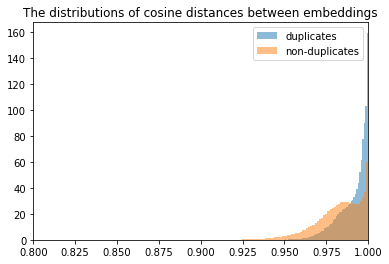

In [23]:
duplicate_similarities = train_df[train_df["is_duplicate"] == 1]["question_similarity"].values
nonduplicate_similarities = train_df[train_df["is_duplicate"] == 0]["question_similarity"].values

plt.hist(duplicate_similarities, bins=100, normed=1, alpha=0.5, label="duplicates")
plt.hist(nonduplicate_similarities, bins=100, normed=1, alpha=0.5, label="non-duplicates")
plt.title("The distributions of cosine distances between embeddings")
plt.xlim([0.8, 1])
plt.legend(loc="best")
plt.show()

The histograms above show that duplicate questions indeed tend to have more similar encodings (more mass is concentrated closer to identical embeddings where cosine distance is one), yet, it would be better if the distances for non-duplicate questions would be shifted more to the left

Alarming fact: the spikes for identical embeddings - may be explained by the fact I calculate word embeddings from scratch and throw away tokens that do not occur frequently enough (without these rare tokens differnt questions may be compressed into the same token list)

Also, I should have trained my RNN for more epochs: in previous reruns of this notebook I managed to get to better final state of the model - there the distribution of embedding distances for non-duplicate questions was centered at 0.95 and had more mass to the left (going back to 0.8 values) 

## Examining pathological cases

In [24]:
pathological_cases = train_df[train_df["is_duplicate"] == 0]
pathological_cases = pathological_cases[pathological_cases["question_similarity"] == 1]
pathological_cases.head(20)

,id,qid1,qid2,question1,question2,is_duplicate,question_similarity
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,1.0
41,41,83,84,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,0,1.0
222,222,445,446,How can I find job in Japan?,How can I find an IT job in Japan?,0,1.0
277,277,554,555,How do most people die?,How do people die?,0,1.0
292,292,584,585,What is CPAGrip.com?,What is bestmytest.com?,0,1.0
298,298,596,597,On what online platforms can I post ads for beer money opportunity?,What online platforms can I post ads for beer money opportunity?,0,1.0
774,774,1543,1544,How is the word 'valiant' used in a sentence?,How is the word 'contorted' used in a sentence?,0,1.0
963,963,1921,1922,What kind of animal did this?,What kind of animal are you?,0,1.0
1188,1188,2368,2369,How can I pass the HP0-M40 exam?,How can I pass the HP0-M33 exam?,0,1.0
1195,1195,2382,2383,Who are you a role model for?,Who is your role model?,0,1.0


Explaining cases where non-duplicate questions have identical encodings (so that their cosine distance equals one) and some ideas how this situation can be tackled in follow-up analysis:
* in general adding more data may lead to richer and more distinct embeddings: as of now I only look at duplicate pairs - however, in some sense every question is a duplicate of itself so I can greatly enhance my dataset my adding all unique questions from the test and training sets
* one way to get better question encodings is to have backward decoding in the model (I assume it is a well-known trick but I have not implemented it so far)
* in some cases the relevant bits could have been filtered with a stoplist - it might make sense to discard all stoplists whatsoever
* in some cases (like for the first pair) punctuation symbols matter - even if I filter stuff out it might make sense to track what share of original question remains for encoding part 
* in some cases the difference lies in just two rare tokens: chances are there are no distinct embeddings for them which ensures identical question embeddings - might make sense to use pretrained word2vec vectors as starting weights before calibrating them to my corpus
* in some cases the tokes are so rare I would not expect to see them among pretrained models: this is a real problem as even if I calculate embeddings for them, these embeddings would be the same (as tokens appear only once or so in identical contexts) so question embeddings would also be the same - to single out these cases I may need to refer to tf-idf features
* in some cases non-duplicate questions are just the same and no model would differentiate them: because of that I will have to clip the probabilities I submit to Kaggle